# Kernel methods and Random features approximation

Now let's step into building a whole pipeline.

Goals:

-  learn about the different ``lightonml`` modules

   -  how to load a dataset

   -  how to encode data

   -  how to perform random projections with the OPU

-  learn why changing the dimensionality of data in machine learning
   problems is helpful.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = np.random.RandomState(42)

## MNIST dataset


The MNIST dataset is composed of 60000 labeled training examples and
10000 labeled test examples of handwritten digits. Each image is 28x28
and in grayscale. The ``lightonml`` loader offers the images already
flattened in arrays of length 784 (28x28). Other datasets are available
in ``lightonml.datasets``.

In [3]:
from lightonml.datasets import MNIST
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = MNIST()

In [4]:
print('Train examples are arrays of shape {} with elements of type {}.'.format(X_train.shape,
                                                                               X_train.dtype))
print('Test examples are arrays of shape {} with elements of type {}.'.format(X_test.shape,
                                                                              X_test.dtype))

Train examples are arrays of shape (60000, 28, 28) with elements of type uint8.
Test examples are arrays of shape (10000, 28, 28) with elements of type uint8.


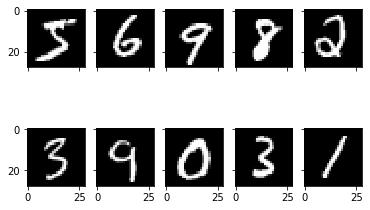

In [5]:
f, axes = plt.subplots(2, 5, sharex='col', sharey='row')

axes[0][0].imshow(X_train[0].reshape(28, 28), cmap='gray')
axes[0][1].imshow(X_train[6000].reshape(28, 28), cmap='gray')
axes[0][2].imshow(X_train[12669].reshape(28, 28), cmap='gray')
axes[0][3].imshow(X_train[19000].reshape(28, 28), cmap='gray')
axes[0][4].imshow(X_train[25020].reshape(28, 28), cmap='gray')
axes[1][0].imshow(X_train[33000].reshape(28, 28), cmap='gray')
axes[1][1].imshow(X_train[39000].reshape(28, 28), cmap='gray')
axes[1][2].imshow(X_train[44000].reshape(28, 28), cmap='gray')
axes[1][3].imshow(X_train[50000].reshape(28, 28), cmap='gray')
axes[1][4].imshow(X_train[55000].reshape(28, 28), cmap='gray')

In [6]:
# convert to float and flatten
X_train_fp = X_train.astype('float').reshape(-1, 784)
X_test_fp = X_test.astype('float').reshape(-1, 784)

In [7]:
print('Min: {}, {}'.format(X_train.min(), X_test.min()))
print('Max: {}, {}'.format(X_train.max(), X_test.max()))
# scale train data
X_train_fp /= 255.
X_test_fp /= 255.
print('Min: {}, {}'.format(X_train.min(), X_test.min()))
print('Max: {}, {}'.format(X_train.max(), X_test.max()))

Min: 0, 0
Max: 255, 255
Min: 0, 0
Max: 255, 255


Ridge regression is a linear model which solves

$$\underset{\beta \in \mathbb{R}^{p \times q}}{\operatorname{argmin}}||\mathbf{X}\beta-\mathbf{Y}||^2_2 + \gamma||\beta||^2_2$$

where $\mathbf{X} \in \mathbb{R}^{n \times p}$ are the sample
images and $\mathbf{Y} \in \mathbb{R}^{n \times q}$ are the
one-hot encoded labels, while $\beta$ are the parameters of the
model.

$n$ is the number of samples, $p$ the number of original features, $q$ the number of classes.


In [8]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier()
clf.fit(X_train_fp, y_train)
train_score = clf.score(X_train_fp, y_train)
test_score = clf.score(X_test_fp, y_test)

print("Train accuracy: {:.4f}".format(train_score))
print("Test accuracy: {:.4f}".format(test_score))

Train accuracy: 0.8574
Test accuracy: 0.8604


## Kernel Ridge Classification and Approximating Kernels

The performance of the standard ridge regression is quite poor, we can
improve it using the kernel trick, but this approach has a major
drawback: we need to invert an $n \times n$ matrix and matrix
inversion is an $O(n^3)$ operation.

We can follow *Random features for large-scale kernel machines*, A.
Rahimi and B. Recht (2007) and solve a standard ridge regression on a
nonlinear mapping of the data to a new feature space of a different
dimension.

Our nonlinear mapping is a linear random projection
$\mathbf{R} \in \mathbb{C}^{m \times p}$ followed by a nonlinear
function $\Phi$:

$$\mathbf{X_{new}} = \Phi(\mathbf{R}\mathbf{X})$$

If we choose $m=10000$, we have now to invert a matrix of size
$10000^2$ instead of $60000^2$.

When the number of random projections $m$ tends to infinity, the
inner product between the projected data points approximates a kernel
function, due to the concentration of measure (*Computation with
infinite neural networks*, C. Williams, 1998).

Random projections have allowed to deal with large-scale machine
learning problem, reaching the point where storing the random matrix and
computing the random features has become the bottleneck of the
algorithm.

We can use the OPU to overcome these problems and compute the random
mapping very quickly and without the need to store a large random matrix.
We can then solve the ridge regression problem on the random features.

## OPU pipeline

### Data and data encoding

The OPU requires a **binary matrix** of type ``uint8`` as input, so we
need to encode our data in binary format. It can be done by using one of
the ``Encoders`` provided in ``lightonml.encoding`` or by building a
custom one.

For grayscale images like MNIST, we can use a very simple
``BinaryThresholdEncoder``, that receives an array of ``uint8`` between
0 and 255 as input and returns an array of zeros and ones of type
``uint8`` according to a threshold. ``SeparatedBitPlanEncoder`` and its
companion ``MixingBitPlanDecoder`` instead work nicely with RGB images.

Another possibility is to train an autoencoder from ``lightonml.encoding.models`` 
on your data.

In [9]:
from lightonml.encoding.base import BinaryThresholdEncoder

In [10]:
encoder = BinaryThresholdEncoder()
print('Encoder threshold: ', encoder.threshold_enc)

Encoder threshold:  25


In [11]:
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

## Random Mapping on the OPU

To use the OPU, we need to initialize an ``OPUMap`` object.

In [12]:
from lightonml.projections.sklearn import OPUMap

Passing `ndims=2` will let the software know that the input is 2D. This parameter will be used in the selection of the optimal display on the input device.

In [13]:
n_components = 10000 # number of random projections
random_mapping = OPUMap(n_components=n_components, ndims=2)

When `OPUMap` is initialized with `opu=None` (default value), an `OPU` object attribute is created: `random_mapping.opu` and the OPU resource is acquired. Resource acquisition takes 3-5 seconds and is a one-time cost. 
The first time you want to transform data through an OPU, you need to call the `fit` method, this will set some internal parameters (e.g. how the input is displayed on the input device) to optimize the quality of the operation. Calling `fit` on different input arrays may affect the result. You can perform the `fit` and the `transform` with a single function call using the `fit_transform` method.

In [14]:
train_random_features = random_mapping.fit_transform(X_train_encoded)
test_random_features = random_mapping.transform(X_test_encoded)

The output type is `uint8`, following operations might be faster converting this to `float32`.

In [15]:
train_random_features.dtype, test_random_features.dtype

(dtype('uint8'), dtype('uint8'))

In [16]:
train_random_features = train_random_features.astype('float32')
test_random_features = test_random_features.astype('float32')

### Decoding

Some encoders, like ``SeparatedBitPlanEncoder``, need a specific decoder
to decode the random features (``MixingBitPlanDecoder``). In this case
we don't need one.

### Model

We will obtain a much better performance than before by using a linear
classifier on the non-linear features.

In [17]:
classifier = RidgeClassifier()

In [18]:
classifier.fit(train_random_features, y_train)
train_accuracy = classifier.score(train_random_features, y_train)
test_accuracy = classifier.score(test_random_features, y_test)

print('Train accuracy: {:.2f} Test accuracy: {:.2f}'.format(train_accuracy * 100, test_accuracy * 100))

Train accuracy: 98.65 Test accuracy: 96.57
